In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# <span style="color:red">ch5_LSTM(RNN, GRN)</span>
- imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정 

# 1. 패키지 import

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score , f1_score
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이남

In [3]:
MY_WORDS = 10000 # imdb 데이터 안의 단어 수
MY_LENGTH = 80 # 독립변수 차원(영화평 단어수 80개로 맞출 예정) 
MY_EMBED = 32 # Embrdding 결과 차원
MY_HIDDEN = 64 # LSTM의 units 수

MY_EPOCH = 10 # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 3. 데이터 불러오기

In [4]:
(X_train, y_train),(X_test, y_test) = imdb.load_data(num_words=MY_WORDS)

In [5]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타켓변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17]
학습용 타켓변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [6]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [7]:
# 긍정 갯수
print('학습테이터의 긍정 갯수 :',y_train.sum())
print('테스트테이터의 긍정 갯수 :',y_test.sum())

학습테이터의 긍정 갯수 : 12500
테스트테이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [8]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어는 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))

17
19
1
movie
film
the


In [9]:
msg = "What a wonderful movie"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자, 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data) :', data)
print('data 추정 :', )

['what', 'a', 'wonderful', 'movie']
원 후기 내용 : ['what', 'a', 'wonderful', 'movie']
encoded된 내용(data) : [1, 51, 6, 389, 20]
data 추정 :


In [10]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', 'a', 'wonderful', 'movie']

# 5. 숫자영화평->자연어 영화평 함수

In [11]:
def decoding(review_nums):
    decoded= [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [12]:
decoding(X_test[0]), y_test[0]

??? please give this one a miss br br ??? ??? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ??? so all you madison fans give this a miss


(None, 0)

# 6. 영화평 학습용 데이터 처음10개의 길이 출력 함수

In [13]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [14]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [15]:
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)

In [17]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       padding='post',
                       #padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 뒤에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       padding='post',
                       # padding='pre' 
                    )
show_length()

첫 20개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


# 8. 최종 데이터 shape 확인

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [19]:
decoding(X_train[0])

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as


# 9. 모델 생성 및 구현

In [20]:
model = Sequential() 
model.add(Embedding(input_dim=MY_WORDS, # 10000
                   output_dim=MY_EMBED, # 32
                   input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
              input_shape=(MY_LENGTH,MY_HIDDEN),
             # kernel_initializer='he_normal', # 입력 가중치 초기화
             # recurrent_initializer='orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [21]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1)
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))


Epoch 1/10
100/100 [==============================] - 14s 120ms/step - loss: 0.5660 - acc: 0.6864 - val_loss: 0.4401 - val_acc: 0.8044
Epoch 2/10
100/100 [==============================] - 13s 126ms/step - loss: 0.3542 - acc: 0.8510 - val_loss: 0.4331 - val_acc: 0.8096
Epoch 3/10
100/100 [==============================] - 13s 131ms/step - loss: 0.2861 - acc: 0.8848 - val_loss: 0.4288 - val_acc: 0.8088
Epoch 4/10
100/100 [==============================] - 12s 121ms/step - loss: 0.2287 - acc: 0.9116 - val_loss: 0.4735 - val_acc: 0.8068
Epoch 5/10
100/100 [==============================] - 13s 129ms/step - loss: 0.1985 - acc: 0.9291 - val_loss: 0.5421 - val_acc: 0.8000
Epoch 6/10
100/100 [==============================] - 13s 132ms/step - loss: 0.1729 - acc: 0.9406 - val_loss: 0.5977 - val_acc: 0.7936
Epoch 7/10
100/100 [==============================] - 14s 142ms/step - loss: 0.1545 - acc: 0.9466 - val_loss: 0.6376 - val_acc: 0.7930
Epoch 8/10
100/100 [==============================] - 1

# 11.모델평가

In [22]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

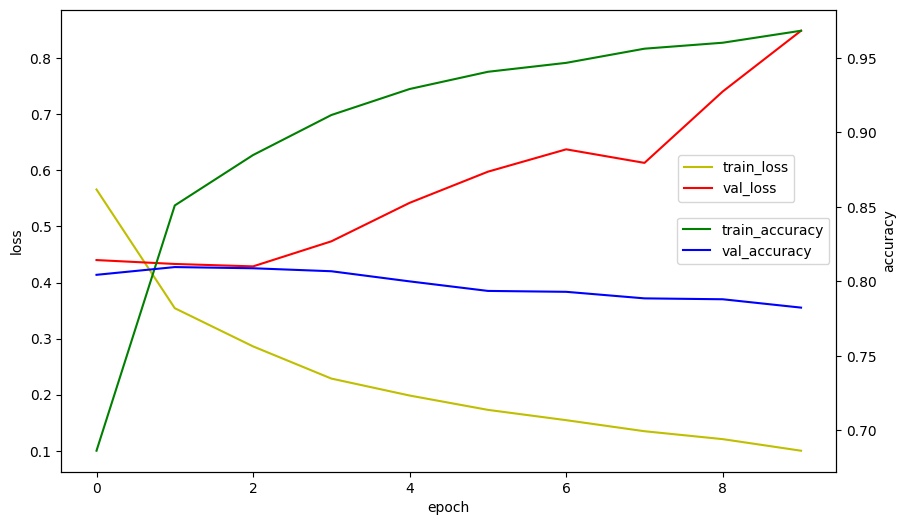

In [23]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [24]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 8s 9ms/step - loss: 0.9550 - acc: 0.7553
test의 데이터 정확도 : 0.7552800178527832
